In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge

## Data

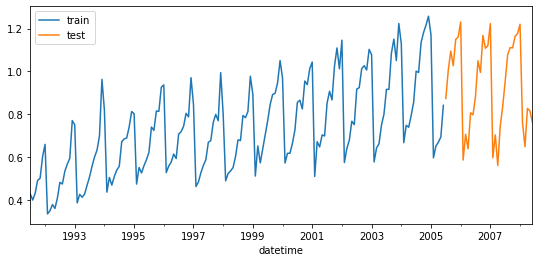

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Prediction intervals

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-03-04 20:19:02 
Last fit date: 2022-03-04 20:19:02 
Skforecast version: 0.4.3.dev5 

In [5]:
# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = 36,
                    interval = [5, 95],
                    n_boot   = 250
              )

predictions.head(4)

,pred,lower_bound,upper_bound
2005-07-01,0.973131,0.876141,1.068890
2005-08-01,1.022154,0.926207,1.130223
2005-09-01,1.151334,1.050965,1.261538
2005-10-01,1.206401,1.109054,1.303380


In [6]:
print(predictions.head(4).to_markdown())

|                     |     pred |   lower_bound |   upper_bound |
|:--------------------|---------:|--------------:|--------------:|
| 2005-07-01 00:00:00 | 0.973131 |      0.876141 |       1.06889 |
| 2005-08-01 00:00:00 | 1.02215  |      0.926207 |       1.13022 |
| 2005-09-01 00:00:00 | 1.15133  |      1.05097  |       1.26154 |
| 2005-10-01 00:00:00 | 1.2064   |      1.10905  |       1.30338 |


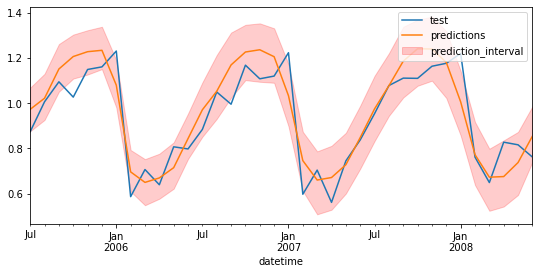

In [7]:
fig, ax=plt.subplots(figsize=(9, 4))
data_test.plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction_interval'
)
ax.legend(loc='upper right');

## Out of sample residuals

By default, training residuals are used to create the prediction intervals. However, other residuals may be used, for example, residuals obtained from a validation set.

First, the new residuals haver o be stored inside the forecaster using the method `set_out_sample_residuals`.

In [8]:
# Simulated residuals
simulated_residuals = pd.Series(np.random.normal(size=500))
forecaster.set_out_sample_residuals(residuals=simulated_residuals)

Once the new residuals have been added to the forecaster, it is possible to indicate `in_sample_residuals = False` when using its method `predict`.

In [10]:
predictions = forecaster.predict_interval(
                    steps    = 36,
                    interval = [5, 95],
                    n_boot   = 250,
                    in_sample_residuals = False
              )